# Kenya Vegetation Health Dataset

In [1]:
%load_ext autoreload
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
    create_test_oxford_run_data
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
ds = pickle.load((base_dir / "data/kenya.pkl").open("rb"))
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    boku_VCI    (time, lat, lon) float64 43.72 31.13 85.88 20.18 ... nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.4688 0.4032 0.624 ... nan nan nan
    VCI         (time, lat, lon) float64 39.64 37.79 89.79 53.54 ... nan nan nan
    precip      (time, lat, lon) float64 13.66 18.42 24.78 47.38 ... nan nan nan
    E           (time, lat, lon) float64 52.86 64.59 64.59 75.49 ... nan nan nan
    Eb          (time, lat, lon) float64 2.3 2.311 2.311 2.409 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2993 0.3273 0.3273 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2837 0.309 0.309 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.121e-05 3.69e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.007123 -0.007165 ... nan nan
    sp          (time, lat, lon) float64 9.591e+04 9.604e+04 ... nan nan
    t2m         (time, lat, lon) float64 303.0 303.8 302.2 299.3 ... nan nan nan
    tp          (time, lat, lon) float64 0.0004198 0.0003483 ... nan nan

# Load in config file

In [4]:
cfg = Config(base_dir / "configs/kenya.yml")
cfg._cfg["n_epochs"] = 2
cfg._cfg["autoregressive"] = True
cfg._cfg["horizon"] = 1
cfg._cfg["seq_length"] = 1
cfg._cfg["device"] = "cpu"
cfg._cfg["scheduler"] = "cycle"
# cfg._cfg["input_variables"] = ["precip"]
cfg._cfg["target_variable"] = "modis_ndvi"
cfg._cfg["model"] = "bilstm"
cfg._cfg["num_workers"] = 1
cfg._cfg["constant_mean"] = None
cfg._cfg["constant_std"] = None
cfg

{'autoregressive': True,
 'batch_size': 100,
 'constant_mean': None,
 'constant_std': None,
 'data_dir': PosixPath('data/kenya.pkl'),
 'device': 'cpu',
 'experiment_name': 'kenya',
 'hidden_size': 64,
 'horizon': 1,
 'input_variables': ['precip', 't2m', 'SMsurf'],
 'learning_rate': 0.001,
 'loss': 'huber',
 'model': 'bilstm',
 'n_epochs': 2,
 'num_workers': 1,
 'optimizer': 'Adam',
 'pixel_dims': ['lat', 'lon'],
 'run_dir': None,
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 1,
 'target_variable': 'modis_ndvi',
 'test_end_date': Timestamp('2020-12-31 00:00:00'),
 'test_start_date': Timestamp('2016-01-31 00:00:00'),
 'train_end_date': Timestamp('2015-12-31 00:00:00'),
 'train_start_date': Timestamp('2002-01-01 00:00:00'),
 'validation_end_date': Timestamp('2002-12-31 00:00:00'),
 'validation_start_date': Timestamp('2000-01-31 00:00:00')}

# Create trainer

In [5]:
trainer = Trainer(cfg, ds)
tester = Tester(cfg, ds)

/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Loading Data: 100%|██████████| 1575/1575 [00:02<00:00, 571.18it/s]


In [6]:
normalizer = trainer.normalizer 
display(normalizer.mean_[cfg.target_variable])

<xarray.DataArray 'modis_ndvi' (sample: 1575)>
array([0.44660952, 0.45750476, 0.47334286, ...,        nan,        nan,
              nan])
Coordinates:
  * sample   (sample) <U11 '6.0_33.75' '6.0_34.0' ... '-5.0_42.0' '-5.0_42.25'

In [7]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/2331 [00:00<?, ?it/s]

Train Loss: 0.28
Valid Loss: 0.24


Validation Epoch 2: 100%|██████████| 155/155 [00:01<00:00, 78.30it/s] 

Train Loss: 0.18
Valid Loss: 0.22


# Check losses of trained model

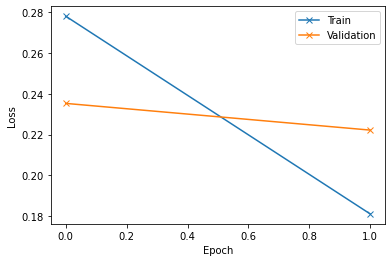

In [8]:
from spatio_temporal.training.eval_utils import _plot_loss_curves

_plot_loss_curves(losses);

# Run Evaluation

Test set Forward Pass: 100%|██████████| 478/478 [00:03<00:00, 150.26it/s]


<xarray.Dataset>
Dimensions:  (pixel: 1405, time: 34)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-30T23:58:53.302898688 ... 2018-12-...
    horizon  int64 1
  * pixel    (pixel) object '-0.25_34.25' '-0.25_34.5' ... '6.0_42.25'
Data variables:
    sim      (time, pixel) float64 -0.0901 -0.05455 -0.05231 ... 0.4724 0.3868
    obs      (time, pixel) float64 0.1328 0.0288 -0.1952 0.4416 ... nan nan nan

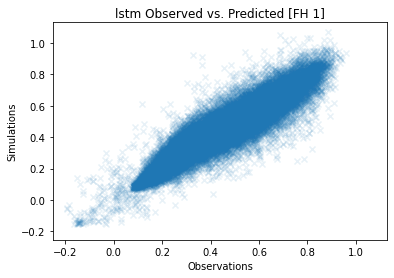

In [9]:
tester.run_test()

In [10]:
out = tester._test_epoch()
normalizer = tester.test_dl.dataset.normalizer

Test set Forward Pass: 100%|██████████| 478/478 [00:03<00:00, 159.23it/s]


In [11]:
preds = tester.test_default_dict_to_xarray(out)
preds["time"] = [pd.to_datetime(t).round("D") for t in preds.time.values]
preds.isel(horizon=0)

<xarray.Dataset>
Dimensions:  (pixel: 1405, time: 34)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31 2016-04-30 ... 2018-12-31
    horizon  int64 1
  * pixel    (pixel) object '-0.25_34.25' '-0.25_34.5' ... '6.0_42.25'
Data variables:
    sim      (time, pixel) float32 -1.093 -1.088 -0.8403 ... 0.142 0.08605
    obs      (time, pixel) float32 0.6337 -0.5212 -1.722 -0.3905 ... nan nan nan

In [12]:
mean = normalizer.mean_.rename({"sample": "pixel"})
std = normalizer.std_.rename({"sample": "pixel"})
target = cfg.target_variable 
unnorm_ds = preds.copy().isel(horizon=0)

for variable in preds.data_vars:
    unnorm_ds[variable] = (unnorm_ds[variable] * std[target]) + mean[target]


# The output forecasts! 

In [13]:
# TODO: convert back to lat, lon
# TODO: unnormalize

In [14]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop(["horizon"])
preds

<xarray.Dataset>
Dimensions:  (pixel: 1405, time: 34)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-30T23:58:53.302898688 ... 2018-12-...
  * pixel    (pixel) object '-0.25_34.25' '-0.25_34.5' ... '6.0_42.25'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

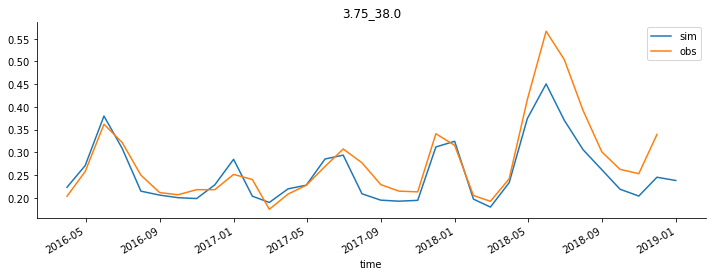

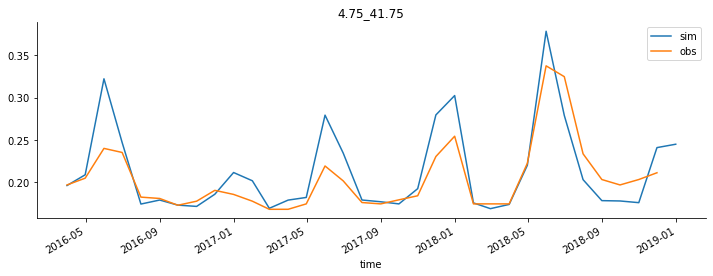

In [17]:
from spatio_temporal.training.eval_utils import _plot_single_timeseries

for _ in range(2):
    _plot_single_timeseries(preds)
    sns.despine()